In [54]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [44]:

def serie_mensual(df:pd.DataFrame, nombre_serie:str):
    df['fecha'] = pd.to_datetime(df['fecha'])
    df['mes'] = df['fecha'].dt.to_period('M')
    ultimo_valor_mes = df.groupby('mes')[nombre_serie].last()
    df[nombre_serie] = df['mes'].map(ultimo_valor_mes)
    df[nombre_serie] = df[nombre_serie].ffill()
    df = df.drop_duplicates(subset='mes')
    return df

PATH_BASES = r'C:\Users\F15239\Desktop\gerardo\tarea6\data\raw'

tasa_de_interes = pd.read_csv(os.path.join(PATH_BASES, 'tasa_de_interes.csv'))
tasa_de_interes = serie_mensual(tasa_de_interes, 'tasa_de_interes')

inflacion = pd.read_csv(os.path.join(PATH_BASES, 'inflacion.csv'))
inflacion = serie_mensual(inflacion, 'inflacion')

tipo_de_cambio = pd.read_csv(os.path.join(PATH_BASES, 'tipo_de_cambio.csv'))
tipo_de_cambio = serie_mensual(tipo_de_cambio, 'tipo_de_cambio')

series = pd.merge(tipo_de_cambio,inflacion, on='mes', how='inner')
series = pd.merge(series,tasa_de_interes, on='mes')
series = series[['mes', 'tipo_de_cambio', 'tasa_de_interes', 'inflacion']]

### 3.1 Regresiones Líneales y scatterplots

#### 3.1.2 tipo_de_cambio ~ tasa_de_interes

RESULTADOS DE LA REGRESIÓN
                            OLS Regression Results                            
Dep. Variable:         tipo_de_cambio   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     123.9
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           6.48e-25
Time:                        17:44:49   Log-Likelihood:                -988.31
No. Observations:                 360   AIC:                             1981.
Df Residuals:                     358   BIC:                             1988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const          

Text(0.5, 0, 'tasa_de_interes')

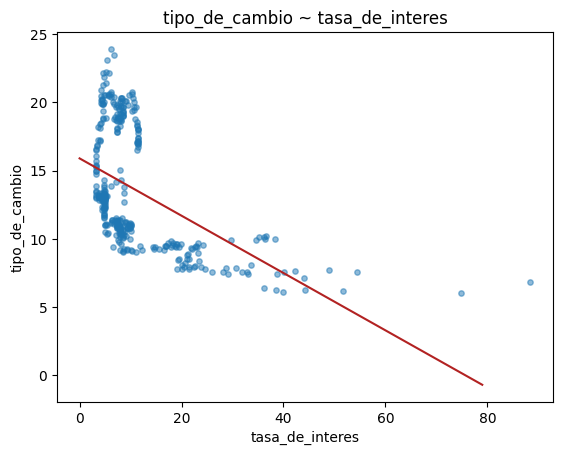

In [99]:
# Regresión
x_var = 'tasa_de_interes'
y_var = 'tipo_de_cambio'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,80,1), const+coef*np.arange(0,80,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)


#### 3.1.2 tasa_de_interes ~ inflacion

RESULTADOS DE LA REGRESIÓN
                            OLS Regression Results                            
Dep. Variable:        tasa_de_interes   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     960.6
Date:                Fri, 14 Mar 2025   Prob (F-statistic):          2.18e-103
Time:                        17:46:33   Log-Likelihood:                -1124.4
No. Observations:                 360   AIC:                             2253.
Df Residuals:                     358   BIC:                             2261.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9949    

(0.0, 60.0)

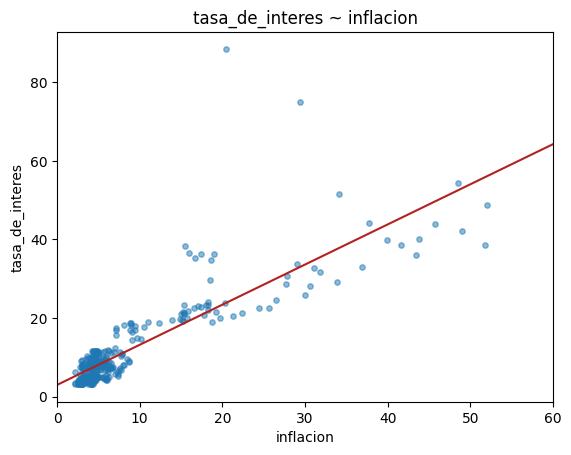

In [102]:
# Regresión
x_var = 'inflacion'
y_var = 'tasa_de_interes'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,80,1), const+coef*np.arange(0,80,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)
ax.set_xlim([0,60])

#### 3.1.3 tipo_de_cambio  ~ inflacion

RESULTADOS DE LA REGRESIÓN
                            OLS Regression Results                            
Dep. Variable:         tipo_de_cambio   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     116.8
Date:                Fri, 14 Mar 2025   Prob (F-statistic):           9.40e-24
Time:                        17:46:50   Log-Likelihood:                -990.98
No. Observations:                 360   AIC:                             1986.
Df Residuals:                     358   BIC:                             1994.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5178    

Text(0.5, 0, 'inflacion')

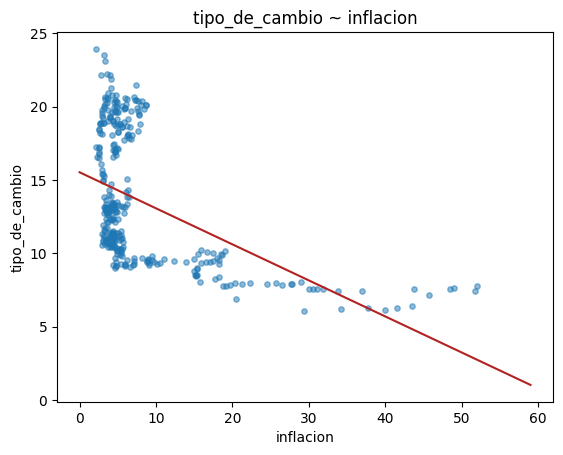

In [103]:
# Regresión
x_var = 'inflacion'
y_var = 'tipo_de_cambio'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,60,1), const+coef*np.arange(0,60,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)